In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] a= 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

In [3]:
# datetime 컬럼 변환
df['event_time_moscow'] = pd.to_datetime(df['event_time_moscow'])

## H1 가격이 높을수록 구매 전환율이 낮다.

In [4]:
print("최소 가격:", df['price'].min())
print("최대 가격:", df['price'].max())
print("price dtype:", df['price'].dtype)

최소 가격: 0.06
최대 가격: 327.78
price dtype: float64


In [5]:
import pandas as pd
import numpy as np

# 가격 필터링
df_price = df[df['price'] > 0].copy()

# 가격 구간 설정
price_bins = [0, 40, 80, 120, 160, 200, 240, 280, 320, 360]
bin_labels = [f"{price_bins[i]}-{price_bins[i+1]-1}" for i in range(len(price_bins)-1)]

# 가격 bin 적용 (right=True: 상한값 포함)
df_price['price_bin'] = pd.cut(df_price['price'], bins=price_bins, labels=bin_labels, right=True)

# view/purchase 수 계산
conversion_by_bin = df_price.groupby(['price_bin', 'event_type'])['user_session'].nunique().unstack(fill_value=0).reset_index()

# 전환률 계산
conversion_by_bin['conversion_rate'] = conversion_by_bin['purchase'] / conversion_by_bin['view']
conversion_by_bin.replace([np.inf, np.nan], 0, inplace=True)

# 결과 정리
conversion_by_bin = conversion_by_bin[['price_bin', 'view', 'purchase', 'conversion_rate']]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22120\2738629097.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_by_bin = df_price.groupby(['price_bin', 'event_type'])['user_session'].nunique().unstack(fill_value=0).reset_index()


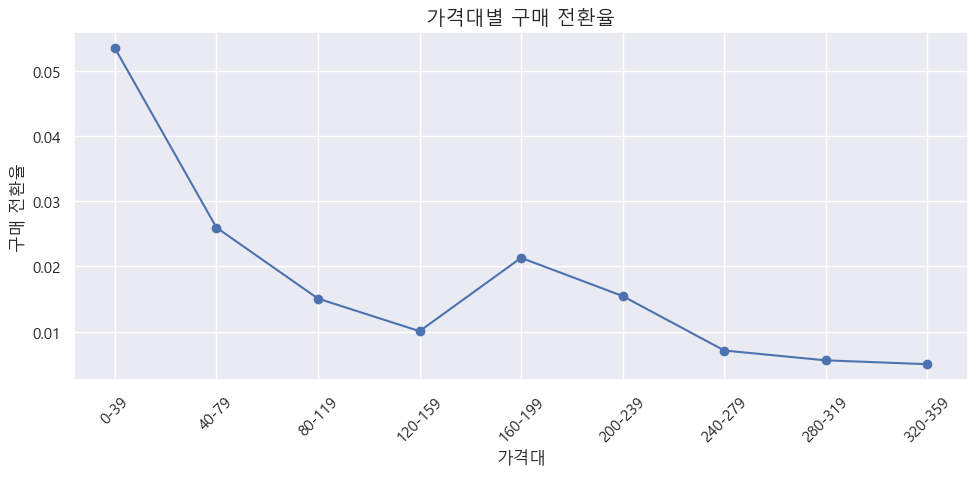

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(conversion_by_bin['price_bin'], conversion_by_bin['conversion_rate'], marker='o', linestyle='-')
plt.title('가격대별 구매 전환율', fontsize=14)
plt.xlabel('가격대', fontsize=12)
plt.ylabel('구매 전환율', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import spearmanr

# bin 중심값 구하기 (예: '0-39' → 19.5)
conversion_by_bin['bin_mid'] = conversion_by_bin['price_bin'].apply(lambda x: 
    (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)

# 상관분석
corr, pval = spearmanr(conversion_by_bin['bin_mid'], conversion_by_bin['conversion_rate'])

print(f"🧪 Spearman 상관계수: {corr:.4f}")
print(f"📉 p-value: {pval:.4f}")


🧪 Spearman 상관계수: -0.8667
📉 p-value: 0.0025


- 스피어만 상관계수 이용
    - 상관계수 -0.8 : 가격대가 클수록 전환율은 낮다.
    - p-avlue < 0.05 : 통계적으로 유의미한 차이를 보인다.

**가격이 높을수록 구매 전환율이 낮다 → True**

## H2 브랜드별 구매 전환율이 다르다.

In [8]:
import pandas as pd

# 브랜드별 view, purchase 수 (user_id 고유 수 기준)
brand_event = df.groupby(['brand', 'event_type'])['user_id'].nunique().unstack(fill_value=0)

# view → purchase 전환율 계산
brand_event['view_to_purchase_rate'] = brand_event['purchase'] / brand_event['view']

# 결측값 또는 무한대(0으로 나눴을 경우) 처리
brand_event.replace([float('inf'), float('nan')], 0, inplace=True)

# 전환율 기준 내림차순 정렬 (선택사항)
brand_event_sorted = brand_event.sort_values(by='view_to_purchase_rate', ascending=False).reset_index()

# 결과 확인
brand_event_sorted[['brand', 'view', 'purchase', 'view_to_purchase_rate']]

event_type,brand,view,purchase,view_to_purchase_rate
0,eunyul,1175,603,0.513191
1,severina,14551,7172,0.492887
2,supertan,352,168,0.477273
3,elskin,1263,578,0.457641
4,cosima,93,40,0.430108
...,...,...,...,...
268,bodipure,29,0,0.000000
269,pueen,1,0,0.000000
270,busch,130,0,0.000000
271,shifei,3,0,0.000000


In [9]:
from scipy.stats import chi2_contingency
import pandas as pd

# 1. 브랜드별 view, purchase 수 (고유 user_id 수 기준)
brand_event = df.groupby(['brand', 'event_type'])['user_id'].nunique().unstack(fill_value=0)

# 2. 구매 전환율 계산 (선택: 보기용)
brand_event['view_to_purchase_rate'] = brand_event['purchase'] / brand_event['view']
brand_event.replace([float('inf'), float('nan')], 0, inplace=True)

# 3. 카이제곱 검정을 위한 교차표 (view vs purchase만 사용)
chi2_table = brand_event[['view', 'purchase']]

# 4. 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(chi2_table)

# 5. 결과 출력
print(f"카이제곱 통계량: {chi2:.2f}")
print(f"자유도 (df): {dof}")
print(f"p-value: {p:.6f}")

# 6. 해석
if p < 0.05:
    print("✅ 브랜드별로 전환율(view → purchase)에 통계적으로 유의한 차이가 있습니다.")
else:
    print("⚠️ 브랜드별 전환율에 유의한 차이가 없다고 볼 수 있습니다.")

카이제곱 통계량: 67630.66
자유도 (df): 272
p-value: 0.000000
✅ 브랜드별로 전환율(view → purchase)에 통계적으로 유의한 차이가 있습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22120\3950016573.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_brands, x='view_to_purchase_rate', y='brand', palette='Blues_d')


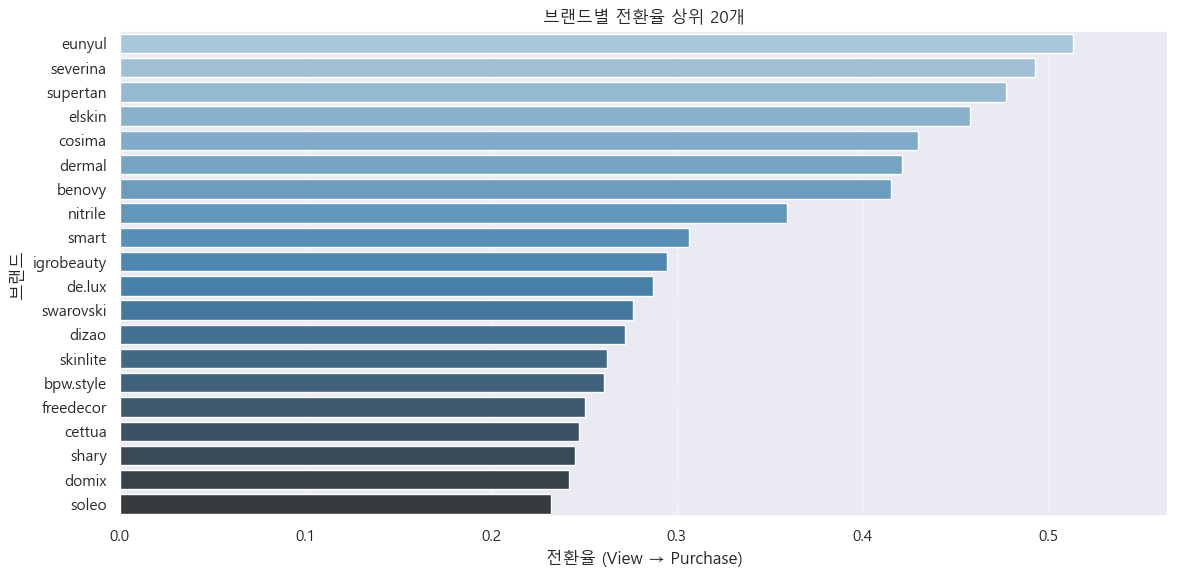

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 N개 브랜드만 시각화 (전체가 너무 많을 경우 보기 어려우므로 상위 20개 추천)
top_n = 20
top_brands = brand_event_sorted.head(top_n)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_brands, x='view_to_purchase_rate', y='brand', palette='Blues_d')

plt.xlabel('전환율 (View → Purchase)')
plt.ylabel('브랜드')
plt.title(f'브랜드별 전환율 상위 {top_n}개')
plt.xlim(0, top_brands['view_to_purchase_rate'].max() * 1.1)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## H3 카테고리별로 구매 전환율이 다르다.

In [10]:
# 교차표 생성
category_event = df[df['event_type'].isin(['view', 'purchase'])] \
    .groupby(['category_id', 'event_type'])['user_id'].nunique().unstack(fill_value=0)

# 교차표 확인
print(category_event)

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(category_event)

print(f"Chi2 통계량: {chi2:.4f}")
print(f"p-value: {p:.6f}")

event_type           purchase  view
category_id                        
1487580004807082827         3    59
1487580004832248652      1006  7217
1487580004857414477      1306  9710
1487580004941300560         9   266
1487580004966466385         0    20
...                       ...   ...
2196456817641391019      1015  4229
2196456817758831535       216  1153
2235524499216793855        34  1234
2235524499636224267         1   121
2242903426784559183         3    74

[438 rows x 2 columns]
Chi2 통계량: 134263.0437
p-value: 0.000000


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22120\3979210462.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_category, x='conversion_rate', y='category_id', palette='Greens_d')


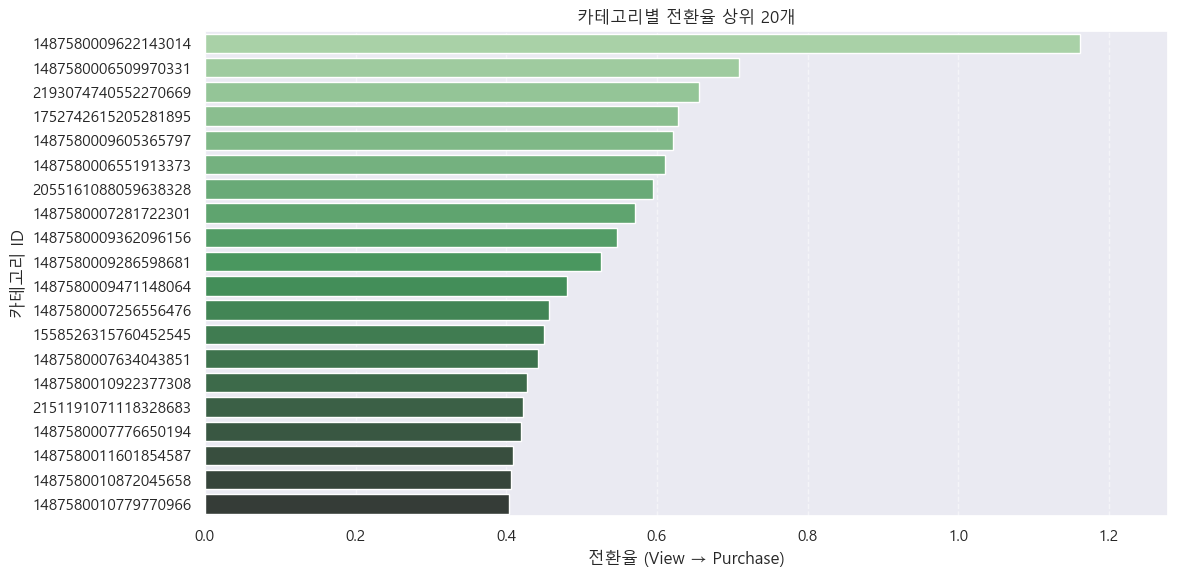

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 전환율 계산
category_event['conversion_rate'] = category_event['purchase'] / category_event['view']
category_event.replace([float('inf'), float('nan')], 0, inplace=True)

# 정렬
category_event_sorted = category_event.sort_values(by='conversion_rate', ascending=False).reset_index()

# 카테고리 ID 문자형 변환
category_event_sorted['category_id'] = category_event_sorted['category_id'].astype(str)

# 상위 20개만 추출
top_n = 20
top_category = category_event_sorted.head(top_n)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_category, x='conversion_rate', y='category_id', palette='Greens_d')

plt.xlabel('전환율 (View → Purchase)')
plt.ylabel('카테고리 ID')
plt.title(f'카테고리별 전환율 상위 {top_n}개')
plt.xlim(0, top_category['conversion_rate'].max() * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## H4 세션당 이벤트 수가 많을수록 구매 확률이 높다.

In [11]:
import statsmodels.api as sm

# 세션별 이벤트 수 계산
session_event_counts = df.groupby('user_session').size().reset_index(name='event_count')

# 세션별 구매 여부 계산
df['purchase_flag'] = (df['event_type'] == 'purchase').astype(int)
session_purchases = df.groupby('user_session')['purchase_flag'].max().reset_index()

# 병합
session_data = pd.merge(session_event_counts, session_purchases, on='user_session')

# 로지스틱 회귀 수행
X = sm.add_constant(session_data['event_count'])  # 절편 포함
y = session_data['purchase_flag']
logit_model = sm.Logit(y, X).fit()

# 결과 확인
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.163990
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          purchase_flag   No. Observations:              3065259
Model:                          Logit   Df Residuals:                  3065257
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 Jul 2025   Pseudo R-squ.:                  0.1060
Time:                        10:28:31   Log-Likelihood:            -5.0267e+05
converged:                       True   LL-Null:                   -5.6228e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4869      0.003  -1032.127      0.000      -3.493      -3.480
event_count     0.0656    

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22120\3997396562.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = session_data.groupby('event_bin')['purchase_flag'].mean().reset_index()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22120\3997396562.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bin_summary, x='event_bin', y='purchase_flag', palette='Blues_d')


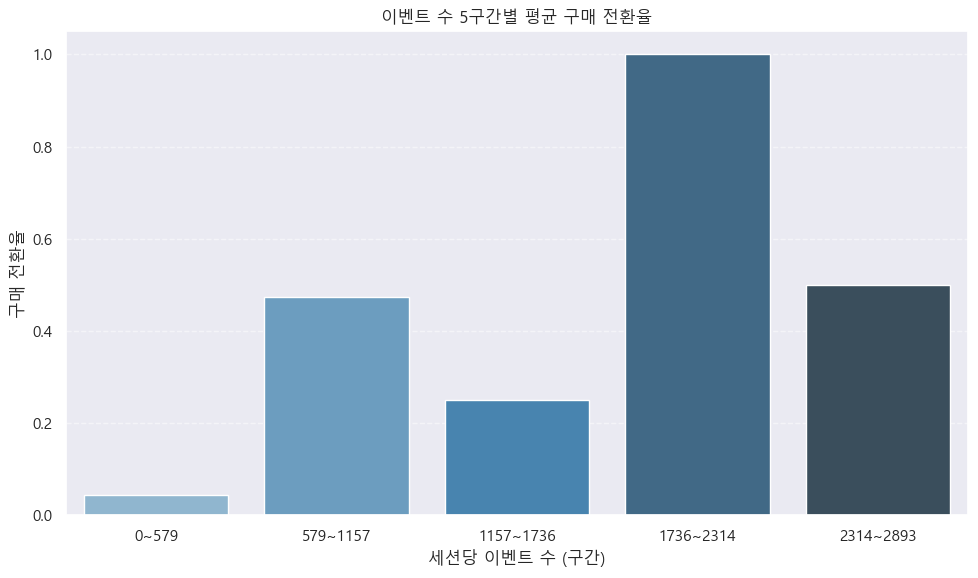

In [25]:
import numpy as np
import pandas as pd

# 1. 최대값 확인
max_event = session_data['event_count'].max()

# 2. 5등분된 경계 생성 (소수점 제거)
bin_edges = np.linspace(0, max_event, num=6)
bin_edges = np.round(bin_edges).astype(int)  # 깔끔하게 정수로

# 3. 구간 라벨 만들기
labels = [f'{bin_edges[i]}~{bin_edges[i+1]}' for i in range(len(bin_edges)-1)]

# 4. bin 분할
session_data['event_bin'] = pd.cut(session_data['event_count'], bins=bin_edges, labels=labels, include_lowest=True, right=True)

# 5. 구매율 요약
bin_summary = session_data.groupby('event_bin')['purchase_flag'].mean().reset_index()

# 6. 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=bin_summary, x='event_bin', y='purchase_flag', palette='Blues_d')

plt.xlabel('세션당 이벤트 수 (구간)')
plt.ylabel('구매 전환율')
plt.title('이벤트 수 5구간별 평균 구매 전환율')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- 이벤트 계수 : 0.6556 (양수)
    - 이벤트 수가 많을수록 구매할 가능성 높아짐
- p-value : 0.000
    - 통계적으로 유의미함

**세션당 이벤트 수가 많을수록 구매 확률이 높다. → True**

## H5 remove_from_cart가 있는 제품은 구매 전환율이 낮다.

In [28]:
# 제품별 이벤트 수 집계 (view, purchase, remove_from_cart)
product_event = df.pivot_table(
    index='product_id',
    columns='event_type',
    values='user_session',
    aggfunc='nunique',
    fill_value=0
).reset_index()

In [29]:
# view가 1건 이상인 제품만 필터링
product_event_filtered = product_event[product_event['view'] > 0].copy()

# 구매 전환율 계산 (purchase/view)
product_event_filtered['conversion_rate'] = product_event_filtered['purchase'] / product_event_filtered['view']

# remove 여부 플래그
product_event_filtered['has_remove'] = product_event_filtered['remove_from_cart'] > 0

In [30]:
# 그룹 나누기
group_with_remove = product_event_filtered[product_event_filtered['has_remove'] == True]['conversion_rate']
group_without_remove = product_event_filtered[product_event_filtered['has_remove'] == False]['conversion_rate']

In [31]:
from scipy.stats import shapiro, levene

# 정규성 검사
print("✅ Shapiro-Wilk Test (remove 있음):", shapiro(group_with_remove))
print("✅ Shapiro-Wilk Test (remove 없음):", shapiro(group_without_remove))

# 등분산성 검사
print("✅ Levene 등분산성 Test:", levene(group_with_remove, group_without_remove))

✅ Shapiro-Wilk Test (remove 있음): ShapiroResult(statistic=np.float64(0.676323890864014), pvalue=np.float64(5.464262594314959e-111))
✅ Shapiro-Wilk Test (remove 없음): ShapiroResult(statistic=np.float64(0.1365235401656275), pvalue=np.float64(1.5341157321143293e-94))
✅ Levene 등분산성 Test: LeveneResult(statistic=np.float64(1700.6012712650352), pvalue=np.float64(0.0))


C:\Users\Administrator\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 25388.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Administrator\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5420.
  res = hypotest_fun_out(*samples, **kwds)


In [40]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(
    group_with_remove,
    group_without_remove,
    alternative='less'      # remove 있음 쪽이 더 낮다고 가정
)

print(f"✅ Mann-Whitney U: U={u_stat:.3f}, p-value={p_val:.6f}")

✅ Mann-Whitney U: U=125039421.500, p-value=1.000000


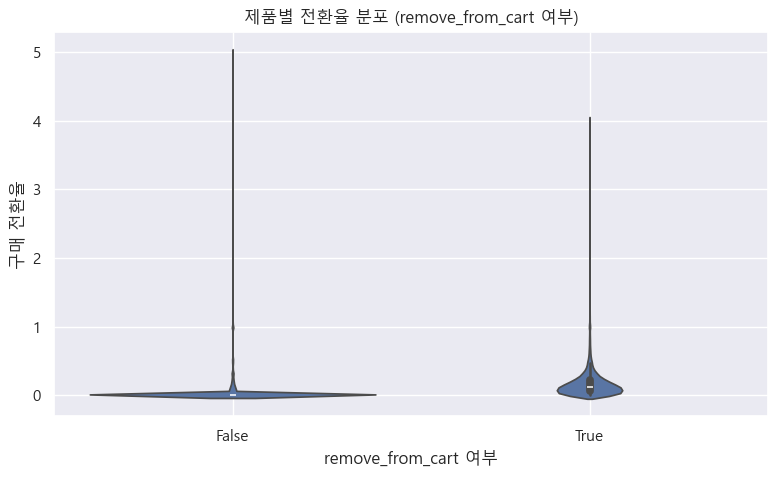

In [41]:
# 시각화용 데이터프레임
plot_df = product_event_filtered[['conversion_rate', 'has_remove']].copy()


plt.figure(figsize=(8, 5))
sns.violinplot(x='has_remove', y='conversion_rate', data=plot_df, inner='box')
plt.title('제품별 전환율 분포 (remove_from_cart 여부)')
plt.xlabel('remove_from_cart 여부')
plt.ylabel('구매 전환율')
plt.grid(True)
plt.tight_layout()
plt.show()

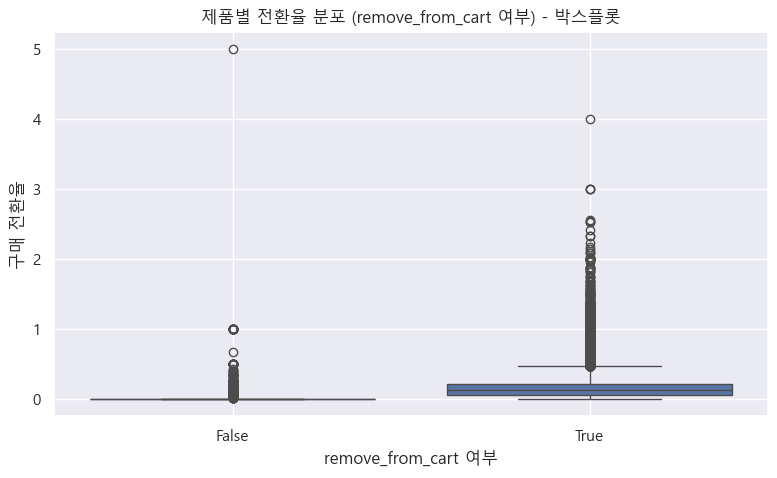

In [42]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='has_remove', y='conversion_rate', data=plot_df)
plt.title('제품별 전환율 분포 (remove_from_cart 여부) - 박스플롯')
plt.xlabel('remove_from_cart 여부')
plt.ylabel('구매 전환율')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
print("remove 있음 중 전환율 0 비율:", (group_with_remove == 0).mean())
print("remove 없음 중 전환율 0 비율:", (group_without_remove == 0).mean())

remove 있음 중 전환율 0 비율: 0.10725539625019695
remove 없음 중 전환율 0 비율: 0.9280442804428044


In [35]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(group_with_remove, group_without_remove, alternative='greater')
print("반대 방향 검정 (remove 있음 > 없음): p-value =", p)

반대 방향 검정 (remove 있음 > 없음): p-value = 0.0


- H5 remove_from_cart가 있는 제품은 구매 전환율이 낮다.
- remove가 있는 그룹과 없는 그룹으로 나눴고, 
- 정규성과 등분산성을 만족하지 않으므로 t-test가 아니라 비모수 검정인 Mann-Whitney U test 사용
- p-vlaue = 1.0이 나와서 시각화해보니, remove가 없는 경우의 구매 전환율이 0인 경우가 굉장히 많음
- 가설 바꿔서 재검정 (remove_from_cart가 있는 제품은 구매 전환율이 높다.)
- p-value = 0.0 만족

**H5 remove_from_cart가 있는 제품은 구매 전환율이 낮다. → False**

**H5_remove_from_cart가 있는 제품은 구매 전환율이 유의미하게 높다.**